In [20]:
import json
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
import sys
from dataclasses import dataclass

In [21]:
 #import sklearn.preprocessing.LabelEncoder()

In [22]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans

In [23]:
import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

In [24]:
import scipy.cluster.hierarchy
import spacy
from spacy import displacy

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from spacy.matcher import Matcher 
from spacy.tokens import Span 

from IPython.display import display, HTML

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

In [25]:
# for topic modelling, document indexing and similarity retrieval with large corpora

import pkg_resources
pkg_resources.require("gensim<=3.8.3")

[gensim 3.6.0 (/usr/local/lib/python3.7/dist-packages),
 numpy 1.21.6 (/usr/local/lib/python3.7/dist-packages),
 smart-open 5.2.1 (/usr/local/lib/python3.7/dist-packages),
 scipy 1.7.3 (/usr/local/lib/python3.7/dist-packages),
 six 1.15.0 (/usr/local/lib/python3.7/dist-packages),
 numpy 1.21.6 (/usr/local/lib/python3.7/dist-packages)]

In [26]:
!python -m spacy download en_core_web_lg -q

2022-08-28 14:57:04.926100: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 587.7 MB 7.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [27]:
nlp = spacy.load('en_core_web_lg')

In [28]:
# NLTK Downloads

nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [29]:
data = pd.read_csv('monster_com-job_sample.csv')
data.head()

country country_code date_added has_expired  \
0  United States of America           US        NaN          No   
1  United States of America           US        NaN          No   
2  United States of America           US        NaN          No   
3  United States of America           US        NaN          No   
4  United States of America           US        NaN          No   

          job_board                                    job_description  \
0  jobs.monster.com  TeamSoft is seeing an IT Support Specialist to...   
1  jobs.monster.com  The Wisconsin State Journal is seeking a flexi...   
2  jobs.monster.com  Report this job About the Job DePuy Synthes Co...   
3  jobs.monster.com  Why Join Altec? If you’re considering a career...   
4  jobs.monster.com  Position ID#  76162 # Positions  1 State  CT C...   

                                           job_title             job_type  \
0               IT Support Technician Job in Madison   Full Time Employee   
1            Business Reporter/Editor Job in Madison            Full Time   
2  Johnson & Johnson Family of Companies Job Appl...  Full Time, Employee   
3                    Engineer - Quality Job in Dixon            Full Time   
4       Shift Supervisor - Part-Time Job in Camphill   Full Time Employee   

                                            location  \
0                                  Madison, WI 53702   
1                                  Madison, WI 53708   
2  DePuy Synthes Companies is a member of Johnson...   
3                                          Dixon, CA   
4                                       Camphill, PA   

                      organization  \
0                              NaN   
1          Printing and Publishing   
2  Personal and Household Services   
3                 Altec Industries   
4                           Retail   

                                            page_url salary  \
0  http://jobview.monster.com/it-support-technici...    NaN   
1  http://jobview.monster.com/business-reporter-e...    NaN   
2  http://jobview.monster.com/senior-training-lea...    NaN   
3  http://jobview.monster.com/engineer-quality-jo...    NaN   
4  http://jobview.monster.com/shift-supervisor-pa...    NaN   

                       sector                           uniq_id  
0     IT/Software Development  11d599f229a80023d2f40e7c52cd941e  
1                         NaN  e4cbb126dabf22159aff90223243ff2a  
2                         NaN  839106b353877fa3d896ffb9c1fe01c0  
3   Experienced (Non-Manager)  58435fcab804439efdcaa7ecca0fd783  
4  Project/Program Management  64d0272dc8496abfd9523a8df63c184c

In [30]:
data.shape

(22000, 14)

In [31]:
data.columns

Index(['country', 'country_code', 'date_added', 'has_expired', 'job_board',
       'job_description', 'job_title', 'job_type', 'location', 'organization',
       'page_url', 'salary', 'sector', 'uniq_id'],
      dtype='object')

In [32]:
dic = {}
for i in data.columns:
  perc = round(data[i].isna().sum()/len(data[i]), 2)
  dic[i] = perc
print(dic)

{'country': 0.0, 'country_code': 0.0, 'date_added': 0.99, 'has_expired': 0.0, 'job_board': 0.0, 'job_description': 0.0, 'job_title': 0.0, 'job_type': 0.07, 'location': 0.0, 'organization': 0.31, 'page_url': 0.0, 'salary': 0.84, 'sector': 0.24, 'uniq_id': 0.0}


In [33]:
# rename columns "organization" and "sector"

df_1 = data.copy()
data = df_1.rename(columns={'organization': 'sector', 'sector': 'old_sector'}) 

In [34]:
# impute the missing data for columns 'sector', 'salary', 'old_sector', 'job_type'

# 1. Fill 'sector''s NaN with the values from 'old_sector' 
data['sector'] = data['sector'].fillna(data['old_sector'])
# If the new value is still NaN, then fill with 'None'
data['sector'] = data['sector'].fillna('Not available')

# 2. Fill 'salary''s NaN with the mode of entries
data['salary'] = data['salary'].fillna(data['salary'].mode()[0])

# 3. Fill 'old_sector''s NaN with 'Not available'
data['old_sector'] = data['old_sector'].fillna('Not available')

# 4. Fill 'job_type''s NaN with the mode of entries
data['job_type'] = data['job_type'].fillna(data['job_type'].mode()[0])

In [35]:
# look at the missing data proportion again

dic = {}
for i in data.columns:
  perc = round(data[i].isna().sum()/len(data[i]), 2)
  dic[i] = perc
print(dic)

{'country': 0.0, 'country_code': 0.0, 'date_added': 0.99, 'has_expired': 0.0, 'job_board': 0.0, 'job_description': 0.0, 'job_title': 0.0, 'job_type': 0.0, 'location': 0.0, 'sector': 0.0, 'page_url': 0.0, 'salary': 0.0, 'old_sector': 0.0, 'uniq_id': 0.0}


# Concatnate values from 'job_title', 'job_description', 'job_type', 'location', 'sector', 'salary' to become a new column for information matching with user's inputs



In [36]:
data['real_answer_des'] = data['job_type'] + '. ' + data['job_title'] + '. ' + data['location'] + '. ' + data['sector'] + '. ' + data['salary'] + '. ' + data['job_description']

In [37]:
data['real_answer'] = data['job_type'] + '. ' + data['job_title'] + '. ' + data['location'] + '. ' + data['sector'] + '. ' + data['salary']

### Data Wrangling Utility Function

In [38]:
#def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    #"""
    #Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    #"""
    #review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    #data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    #data = pd.read_csv(path)
    #add_movie_descriptor(data, data)
    sorted_data = subdata.sort_values(['job_title'])
    indexed_data = sorted_data.reset_index()
    #indexed_data = sorted_data.set_index(['uniq_id'])
    indexed_data['job_id'] = indexed_data.index
    return indexed_data
    #return sorted_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

#def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    #doc= ' '.join(remove_stop_words(doc))
    #doc = apply_lemmatization(doc)
    #return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count


In [157]:

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
    data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
    data['is_action'] = data.index.isin(action_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=preprocessing.LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=preprocessing.OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

In [128]:
# Create a function to start and keep conversations with questions.


def chatbot():
  sector_name = 0
  input_answer = ''
  while True:
    if remove_punctuation(input('Are you looking for a job in the US? Yes/No')) in ['Yes', 'yes']:
      country = 'US'
      if True:
        input_answer = input_answer + str(input('What type of employment are you looking for? Full Time, Part Time, Temporary/Contract/Project, or Intern.')) + ' '
        if True:
          input_answer = input_answer + str(input('What job title of the role are you looking for?')) + ' '
          if True:
            input_answer = input_answer + str(input('What location (format: City, State abbreviation) are you looking for?')) + ' '
            if True:
              input_answer = input_answer + str(input('What sector are you expecting to work at?')) + ' '
              if True:
                input_answer = input_answer + str(input('What salary (or range) are you expecting to have?')) + ' '
                #return 'We found these jobs matching with your expectation.' # The output of NLP model to get the best match!!!
                return input_answer
                sys.exit(1)
              else:
                input_answer.append(input('Please input a valid number or range for this question.'))
            else:
              input_answer.append(input('Please input a valid value for sector, for instance, Retail, Finance, or Technology.'))
          else:
            input_answer.append(input('Please input a valid value for location in the right format, "City, State abbreviation".'))
        else:
          input_answer.append(input('Please input a valid value for job title that you are looking for.'))
      else: 
        input_answer.append(input('Please input a valid value for the type of employment from these options, Full Time, Part Time, Temporary/Contract/Project, or Intern.'))

              

In [129]:
# Implement the Chatbot

chatbot()

Are you looking for a job in the US? Yes/NoYes
What type of employment are you looking for? Full Time, Part Time, Temporary/Contract/Project, or Intern.Full Time
What job title of the role are you looking for?Co-manager
What location (format: City, State abbreviation) are you looking for?Austin, TX
What sector are you expecting to work at?Sales
What salary (or range) are you expecting to have?70,000/year


'Full Time Co-manager Austin, TX Sales 70,000/year '

In [132]:
input_answer = 'Full Time Co-manager Austin, TX Sales 70,000/year '

In [42]:
sector_name = 'Sales'

### Subset the data set by 'sector' input by the user.

In [43]:
# Suppose the sector input by the user is 'Retail'

subdata = data[data['sector'].str.contains(sector_name)]
subdata.shape

(409, 16)

### Topic Summarization
### Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix¶

In [44]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
            
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=100
                        ,random_state=23
                        ,passes=20)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)
    
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

### Visualization Utility Functions

In [47]:
def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

In [49]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Knowledge Context Graph Functions

In [50]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

### Entity Extraction Functions

In [51]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

### Manipulate Data

In [52]:
subdata.shape

(409, 16)

In [53]:
corpus_df = get_corpus_df(subdata) 

In [54]:
corpus_df.shape 

(409, 18)

In [55]:
corpus_df.head(5)

index                   country country_code date_added has_expired  \
0   8731  United States of America           US        NaN          No   
1   9021  United States of America           US        NaN          No   
2  15926  United States of America           US        NaN          No   
3  15954  United States of America           US        NaN          No   
4  20671  United States of America           US        NaN          No   

          job_board                                    job_description  \
0  jobs.monster.com  Apply Today. Train Tomorrow. Earn This Week!!A...   
1  jobs.monster.com  Apex Equipment, the leading trash and hauling ...   
2  jobs.monster.com  Job Overview:The MMG Private Brands Stock Supp...   
3  jobs.monster.com  JOB OVERVIEW:The Draw vs. Commission Sales Ass...   
4  jobs.monster.com  JOB OVERVIEW:With a role in the Macy's Cosmeti...   

                                           job_title            job_type  \
0                                    !!! Apply Today           Full Time   
1  ** EXPERIENCED DIESEL MECHANIC**TOP PAY OFFERE...           Full Time   
2  **Private Brand Stock Support (PBSS) - Retail ...  Part Time Employee   
3  **Retail Commission Sales - Men's Clothing/Sho...  Full Time Employee   
4  **Retail Cosmetics Sales - Beauty Advisor Este...  Part Time Employee   

                    location                                sector  \
0                 Austin, TX     Sales/Retail/Business Development   
1  West Palm Beach, FL 33407  Automotive Sales and Repair Services   
2             Cincinnati, OH     Sales/Retail/Business Development   
3             Cincinnati, OH     Sales/Retail/Business Development   
4              Arlington, VA     Sales/Retail/Business Development   

                                            page_url  \
0  http://jobview.monster.com/!!!-apply-today-800...   
1  http://jobview.monster.com/EXPERIENCED-DIESEL-...   
2  http://jobview.monster.com/private-brand-stock...   
3  http://jobview.monster.com/retail-commission-s...   
4  http://jobview.monster.com/retail-cosmetics-sa...   

                           salary                         old_sector  \
0        0.00 - 70,000.00 $ /year  Sales/Retail/Business Development   
1  40,000.00 - 100,000.00 $ /year          Experienced (Non-Manager)   
2  40,000.00 - 100,000.00 $ /year  Sales/Retail/Business Development   
3  40,000.00 - 100,000.00 $ /year  Sales/Retail/Business Development   
4  40,000.00 - 100,000.00 $ /year  Sales/Retail/Business Development   

                            uniq_id  \
0  0bde742227430ed8ea3cccff25687806   
1  535a91eb8db5c871c2a88b039a69c327   
2  7ef93671d7794120acaec0ac6adc9184   
3  de731bcc8241f5765e9c5a665a85e60a   
4  285d5cb754d84b39a8f167c873a2b7da   

                                     real_answer_des  \
0  Full Time. !!! Apply Today. Austin, TX. Sales/...   
1  Full Time. ** EXPERIENCED DIESEL MECHANIC**TOP...   
2  Part Time Employee. **Private Brand Stock Supp...   
3  Full Time Employee. **Retail Commission Sales ...   
4  Part Time Employee. **Retail Cosmetics Sales -...   

                                         real_answer  job_id  
0  Full Time. !!! Apply Today. Austin, TX. Sales/...       0  
1  Full Time. ** EXPERIENCED DIESEL MECHANIC**TOP...       1  
2  Part Time Employee. **Private Brand Stock Supp...       2  
3  Full Time Employee. **Retail Commission Sales ...       3  
4  Part Time Employee. **Retail Cosmetics Sales -...       4

### Exploratory Analysis

In [56]:
#adding two columns to the dataframe to store the processed text and tokenized text
corpus_df['processed_text'] = corpus_df.real_answer.apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in corpus_df['processed_text'].tolist()]
titles = corpus_df['job_id'].tolist()
processed_text = corpus_df['processed_text'].tolist()

### LSA for summarizing topic

[(0, '0.382*"sales" + 0.226*"customers" + 0.213*"customer" + 0.207*"store" + 0.191*"position" + 0.157*"development" + 0.138*"salesretailbusiness" + 0.130*"merchandise" + 0.130*"service" + 0.120*"management"'), (1, '0.466*"sales" + 0.246*"employee" + -0.205*"store" + -0.188*"guest" + 0.185*"services" + 0.184*"automotive" + 0.160*"repair" + 0.141*"account" + 0.139*"manager" + 0.129*"development"'), (2, '0.308*"perficient" + -0.236*"sales" + 0.193*"experience" + -0.176*"automotive" + -0.174*"employee" + 0.174*"partner" + -0.164*"salesretailbusiness" + 0.161*"business" + -0.146*"repair" + -0.142*"development"'), (3, '0.396*"guest" + -0.259*"customer" + 0.225*"employee" + 0.210*"development" + -0.199*"customers" + 0.198*"checks" + 0.189*"salesretailbusiness" + 0.151*"perficient" + 0.112*"information" + -0.108*"product"'), (4, '0.391*"studio" + 0.359*"pilates" + 0.196*"instructors" + -0.173*"perficient" + 0.144*"guest" + 0.130*"classes" + 0.125*"clients" + 0.109*"phone" + 0.107*"ability" + 0

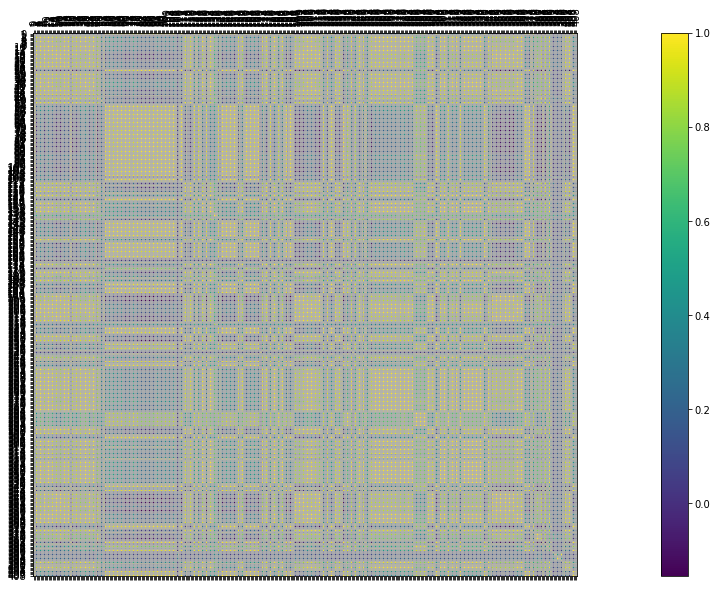

In [60]:
model_10topic_10words = plot_lsa(10, 10) # 10 topic: 10 categories of job_titles, use 10 words to summarize "processed_text" 

[(0, '0.382*"sales" + 0.226*"customers" + 0.213*"customer" + 0.207*"store" + 0.191*"position" + 0.157*"development" + 0.138*"salesretailbusiness" + 0.130*"merchandise" + 0.130*"service" + 0.120*"management"'), (1, '-0.466*"sales" + -0.246*"employee" + 0.205*"store" + 0.188*"guest" + -0.185*"services" + -0.184*"automotive" + -0.160*"repair" + -0.141*"account" + -0.139*"manager" + -0.129*"development"'), (2, '-0.308*"perficient" + 0.236*"sales" + -0.193*"experience" + 0.176*"automotive" + 0.174*"employee" + -0.174*"partner" + 0.164*"salesretailbusiness" + -0.161*"business" + 0.146*"repair" + 0.142*"development"'), (3, '0.396*"guest" + -0.259*"customer" + 0.225*"employee" + 0.210*"development" + -0.199*"customers" + 0.198*"checks" + 0.189*"salesretailbusiness" + 0.151*"perficient" + 0.112*"information" + -0.108*"product"'), (4, '0.391*"studio" + 0.359*"pilates" + 0.196*"instructors" + -0.173*"perficient" + 0.144*"guest" + 0.130*"classes" + 0.125*"clients" + 0.109*"phone" + 0.107*"ability"

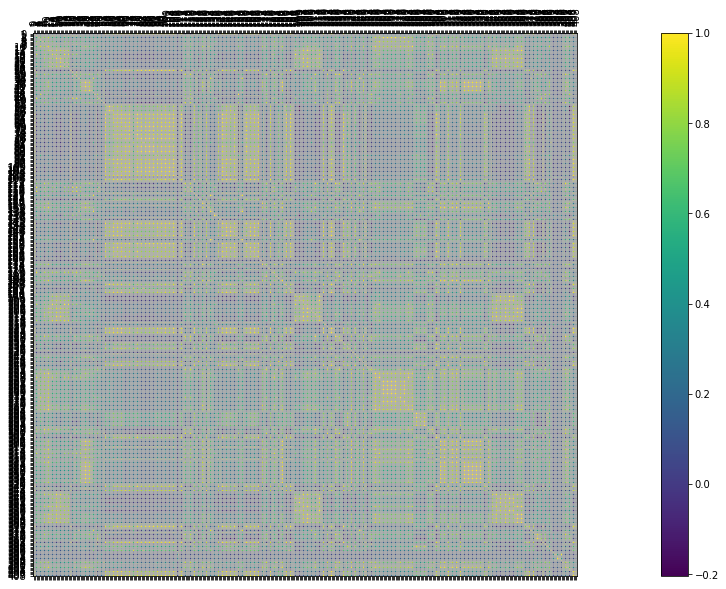

In [61]:
model_20topic_10words = plot_lsa(20, 10) # 20 topic: 20 categories of job_titles, use 10 words to summarize "processed_text"

[(0, '0.382*"sales" + 0.226*"customers" + 0.213*"customer" + 0.207*"store" + 0.191*"position" + 0.157*"development" + 0.138*"salesretailbusiness" + 0.130*"merchandise" + 0.130*"service" + 0.120*"management"'), (1, '-0.466*"sales" + -0.246*"employee" + 0.205*"store" + 0.188*"guest" + -0.185*"services" + -0.184*"automotive" + -0.160*"repair" + -0.141*"account" + -0.139*"manager" + -0.129*"development"'), (2, '0.308*"perficient" + -0.236*"sales" + 0.193*"experience" + -0.176*"automotive" + -0.174*"employee" + 0.174*"partner" + -0.164*"salesretailbusiness" + 0.161*"business" + -0.146*"repair" + -0.142*"development"'), (3, '0.396*"guest" + -0.259*"customer" + 0.225*"employee" + 0.210*"development" + -0.199*"customers" + 0.198*"checks" + 0.189*"salesretailbusiness" + 0.151*"perficient" + 0.112*"information" + -0.108*"product"'), (4, '0.391*"studio" + 0.359*"pilates" + 0.196*"instructors" + -0.173*"perficient" + 0.144*"guest" + 0.130*"classes" + 0.125*"clients" + 0.109*"phone" + 0.107*"abilit

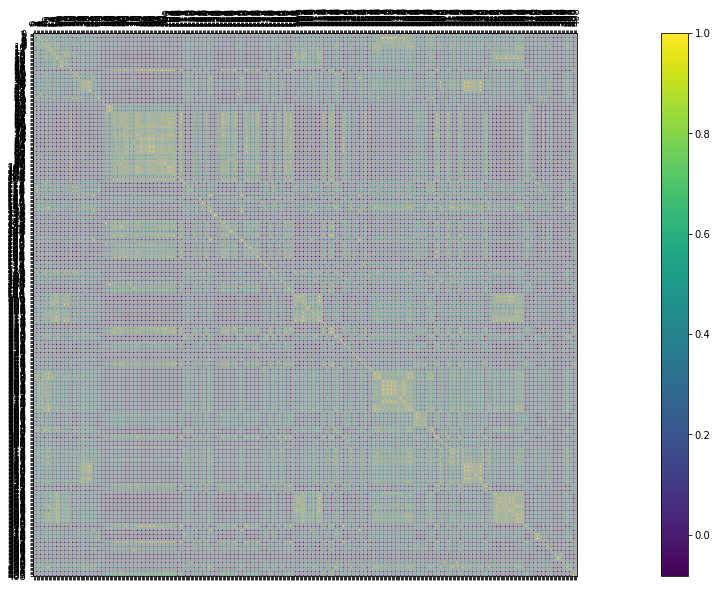

In [62]:
model_50topic_10words = plot_lsa(50, 10) # 50 topic: 50 categories of job_titles, use 10 words to summarize "processed_text" 

[(0, '0.382*"sales" + 0.226*"customers" + 0.213*"customer" + 0.207*"store" + 0.191*"position" + 0.157*"development" + 0.138*"salesretailbusiness" + 0.130*"merchandise" + 0.130*"service" + 0.120*"management"'), (1, '0.466*"sales" + 0.246*"employee" + -0.205*"store" + -0.188*"guest" + 0.185*"services" + 0.184*"automotive" + 0.160*"repair" + 0.141*"account" + 0.139*"manager" + 0.129*"development"'), (2, '-0.308*"perficient" + 0.236*"sales" + -0.193*"experience" + 0.176*"automotive" + 0.174*"employee" + -0.174*"partner" + 0.164*"salesretailbusiness" + -0.161*"business" + 0.146*"repair" + 0.142*"development"'), (3, '-0.396*"guest" + 0.259*"customer" + -0.225*"employee" + -0.210*"development" + 0.199*"customers" + -0.198*"checks" + -0.189*"salesretailbusiness" + -0.151*"perficient" + -0.112*"information" + 0.108*"product"'), (4, '-0.391*"studio" + -0.359*"pilates" + -0.196*"instructors" + 0.173*"perficient" + -0.144*"guest" + -0.130*"classes" + -0.125*"clients" + -0.109*"phone" + -0.107*"abi

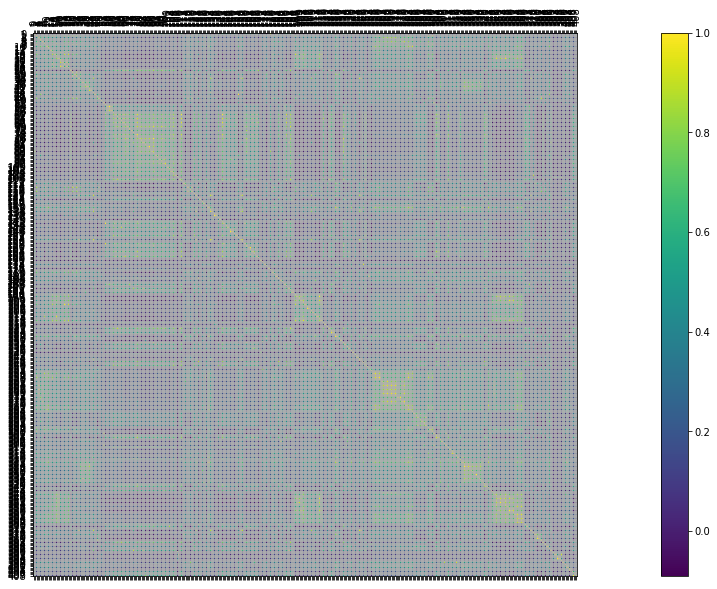

In [63]:
model_100topic_10words = plot_lsa(100, 10) # 100 topic: 100 categories of job_titles, use 10 words to summarize "processed_text" 

[(0, '-0.382*"sales" + -0.226*"customers" + -0.213*"customer" + -0.207*"store" + -0.191*"position" + -0.157*"development" + -0.138*"salesretailbusiness" + -0.130*"merchandise" + -0.130*"service" + -0.120*"management"'), (1, '0.466*"sales" + 0.246*"employee" + -0.205*"store" + -0.188*"guest" + 0.185*"services" + 0.184*"automotive" + 0.160*"repair" + 0.141*"account" + 0.139*"manager" + 0.129*"development"'), (2, '-0.308*"perficient" + 0.236*"sales" + -0.193*"experience" + 0.176*"automotive" + 0.174*"employee" + -0.174*"partner" + 0.164*"salesretailbusiness" + -0.161*"business" + 0.146*"repair" + 0.142*"development"'), (3, '0.396*"guest" + -0.259*"customer" + 0.225*"employee" + 0.210*"development" + -0.199*"customers" + 0.198*"checks" + 0.189*"salesretailbusiness" + 0.151*"perficient" + 0.112*"information" + -0.108*"product"'), (4, '0.391*"studio" + 0.359*"pilates" + 0.196*"instructors" + -0.173*"perficient" + 0.144*"guest" + 0.130*"classes" + 0.125*"clients" + 0.109*"phone" + 0.107*"abil

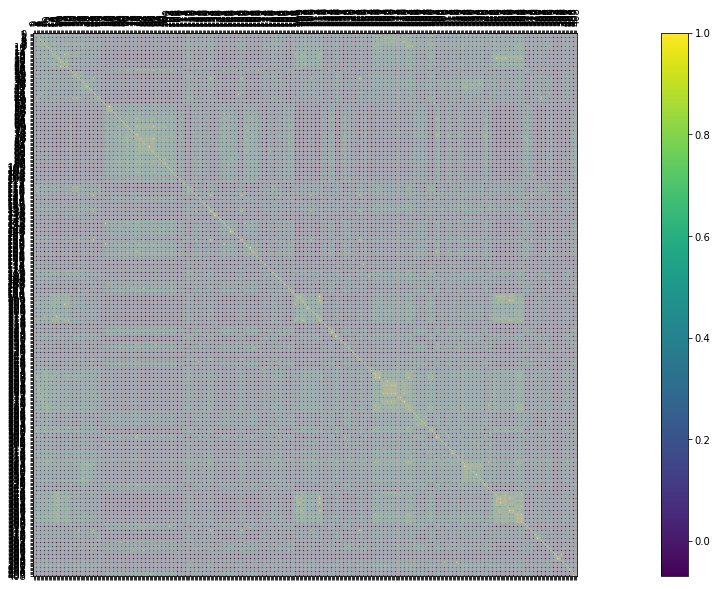

In [64]:
model_150topic_10words = plot_lsa(150, 10) # 150 topic: 150 categories of job_titles, use 10 words to summarize "processed_text" 

In [65]:
### Compare different 

topics = [10, 20, 50, 100, 150]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'10 topic 10 words':coherence_values[0],
           '20 topic 10 words': coherence_values[1],
           '50 topic 10 words':coherence_values[2],
           '100 topic 10 words': coherence_values[3],
            '150 topic 10 words': coherence_values[4]
            }

print(coherence)

[(0, '0.382*"sales" + 0.226*"customers" + 0.213*"customer" + 0.207*"store" + 0.191*"position" + 0.157*"development" + 0.138*"salesretailbusiness" + 0.130*"merchandise" + 0.130*"service" + 0.120*"management"'), (1, '-0.466*"sales" + -0.246*"employee" + 0.205*"store" + 0.188*"guest" + -0.185*"services" + -0.184*"automotive" + -0.160*"repair" + -0.141*"account" + -0.139*"manager" + -0.129*"development"'), (2, '-0.308*"perficient" + 0.236*"sales" + -0.193*"experience" + 0.176*"automotive" + 0.174*"employee" + -0.174*"partner" + 0.164*"salesretailbusiness" + -0.161*"business" + 0.146*"repair" + 0.142*"development"'), (3, '0.396*"guest" + -0.259*"customer" + 0.225*"employee" + 0.210*"development" + -0.199*"customers" + 0.198*"checks" + 0.189*"salesretailbusiness" + 0.151*"perficient" + 0.112*"information" + -0.108*"product"'), (4, '0.391*"studio" + 0.359*"pilates" + 0.196*"instructors" + -0.173*"perficient" + 0.144*"guest" + 0.130*"classes" + 0.125*"clients" + 0.109*"phone" + 0.107*"ability"

[(0, '0.382*"sales" + 0.226*"customers" + 0.213*"customer" + 0.207*"store" + 0.191*"position" + 0.157*"development" + 0.138*"salesretailbusiness" + 0.130*"merchandise" + 0.130*"service" + 0.120*"management"'), (1, '0.466*"sales" + 0.246*"employee" + -0.205*"store" + -0.188*"guest" + 0.185*"services" + 0.184*"automotive" + 0.160*"repair" + 0.141*"account" + 0.139*"manager" + 0.129*"development"'), (2, '-0.308*"perficient" + 0.236*"sales" + -0.193*"experience" + 0.176*"automotive" + 0.174*"employee" + -0.174*"partner" + 0.164*"salesretailbusiness" + -0.161*"business" + 0.146*"repair" + 0.142*"development"'), (3, '0.396*"guest" + -0.259*"customer" + 0.225*"employee" + 0.210*"development" + -0.199*"customers" + 0.198*"checks" + 0.189*"salesretailbusiness" + 0.151*"perficient" + 0.112*"information" + -0.108*"product"'), (4, '-0.391*"studio" + -0.359*"pilates" + -0.196*"instructors" + 0.173*"perficient" + -0.144*"guest" + -0.130*"classes" + -0.125*"clients" + -0.109*"phone" + -0.107*"ability

[(0, '0.382*"sales" + 0.226*"customers" + 0.213*"customer" + 0.207*"store" + 0.191*"position" + 0.157*"development" + 0.138*"salesretailbusiness" + 0.130*"merchandise" + 0.130*"service" + 0.120*"management"'), (1, '-0.466*"sales" + -0.246*"employee" + 0.205*"store" + 0.188*"guest" + -0.185*"services" + -0.184*"automotive" + -0.160*"repair" + -0.141*"account" + -0.139*"manager" + -0.129*"development"'), (2, '0.308*"perficient" + -0.236*"sales" + 0.193*"experience" + -0.176*"automotive" + -0.174*"employee" + 0.174*"partner" + -0.164*"salesretailbusiness" + 0.161*"business" + -0.146*"repair" + -0.142*"development"'), (3, '-0.396*"guest" + 0.259*"customer" + -0.225*"employee" + -0.210*"development" + 0.199*"customers" + -0.198*"checks" + -0.189*"salesretailbusiness" + -0.151*"perficient" + -0.112*"information" + 0.108*"product"'), (4, '0.391*"studio" + 0.359*"pilates" + 0.196*"instructors" + -0.173*"perficient" + 0.144*"guest" + 0.130*"classes" + 0.125*"clients" + 0.109*"phone" + 0.107*"ab

[(0, '0.382*"sales" + 0.226*"customers" + 0.213*"customer" + 0.207*"store" + 0.191*"position" + 0.157*"development" + 0.138*"salesretailbusiness" + 0.130*"merchandise" + 0.130*"service" + 0.120*"management"'), (1, '0.466*"sales" + 0.246*"employee" + -0.205*"store" + -0.188*"guest" + 0.185*"services" + 0.184*"automotive" + 0.160*"repair" + 0.141*"account" + 0.139*"manager" + 0.129*"development"'), (2, '-0.308*"perficient" + 0.236*"sales" + -0.193*"experience" + 0.176*"automotive" + 0.174*"employee" + -0.174*"partner" + 0.164*"salesretailbusiness" + -0.161*"business" + 0.146*"repair" + 0.142*"development"'), (3, '0.396*"guest" + -0.259*"customer" + 0.225*"employee" + 0.210*"development" + -0.199*"customers" + 0.198*"checks" + 0.189*"salesretailbusiness" + 0.151*"perficient" + 0.112*"information" + -0.108*"product"'), (4, '0.391*"studio" + 0.359*"pilates" + 0.196*"instructors" + -0.173*"perficient" + 0.144*"guest" + 0.130*"classes" + 0.125*"clients" + 0.109*"phone" + 0.107*"ability" + 0.0

[(0, '-0.382*"sales" + -0.226*"customers" + -0.213*"customer" + -0.207*"store" + -0.191*"position" + -0.157*"development" + -0.138*"salesretailbusiness" + -0.130*"merchandise" + -0.130*"service" + -0.120*"management"'), (1, '-0.466*"sales" + -0.246*"employee" + 0.205*"store" + 0.188*"guest" + -0.185*"services" + -0.184*"automotive" + -0.160*"repair" + -0.141*"account" + -0.139*"manager" + -0.129*"development"'), (2, '-0.308*"perficient" + 0.236*"sales" + -0.193*"experience" + 0.176*"automotive" + 0.174*"employee" + -0.174*"partner" + 0.164*"salesretailbusiness" + -0.161*"business" + 0.146*"repair" + 0.142*"development"'), (3, '0.396*"guest" + -0.259*"customer" + 0.225*"employee" + 0.210*"development" + -0.199*"customers" + 0.198*"checks" + 0.189*"salesretailbusiness" + 0.151*"perficient" + 0.112*"information" + -0.108*"product"'), (4, '-0.391*"studio" + -0.359*"pilates" + -0.196*"instructors" + 0.173*"perficient" + -0.144*"guest" + -0.130*"classes" + -0.125*"clients" + -0.109*"phone" +

In [57]:
# Tokenize sentences for following analysis

corpus_df['raw_sentences'] = corpus_df['real_answer'].apply(get_sentences)

### Tokenize Words

In [58]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})

In [59]:
corpus_df['lemmas'] = corpus_df['real_answer'].apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

0    [time, apply, today, austin, tx, sale, retail,...
1    [time, experienced, diesel, mechanictop, pay, ...
2    [time, employee, private, brand, stock, suppor...
3    [time, employee, retail, commission, sales, me...
4    [time, employee, retail, cosmetics, sales, bea...
Name: lemmas, dtype: object

### Reassemble Leminized Words

In [66]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

### Vocabulary Data Wrangling

In [67]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.job_id)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.9)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.job_id)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 1669
Curated Vocabulary size: 361


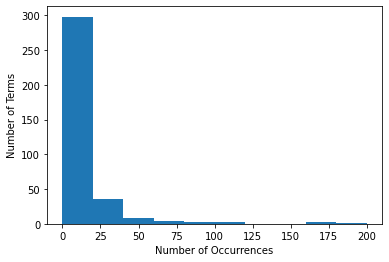

In [69]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [70]:
# Re-tokenize words, recreate joined documents

corpus_df['lemmas'] = corpus_df.real_answer.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

0            [tx, sale, retail, business, development]
1    [diesel, pay, offer, job, west, palm, beach, w...
2    [employee, stock, support, retail, development...
3    [employee, retail, commission, sales, cincinna...
4    [employee, retail, cosmetics, sales, beauty, a...
Name: lemmas, dtype: object

In [71]:
corpus_df.lemmas_joined.head()

0                  tx sale retail business development
1    diesel pay offer job west palm beach west palm...
2    employee stock support retail development cinc...
3    employee retail commission sales cincinnati ci...
4    employee retail cosmetics sales beauty advisor...
Name: lemmas_joined, dtype: object

### Get Lemmatized and Filtered Sentences

In [72]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [73]:
corpus_df.raw_sentences.head()

0    [Full Time. !!!, Apply Today., Austin, TX., Sa...
1    [Full Time., ** EXPERIENCED DIESEL MECHANIC**T...
2    [Part Time Employee., **Private Brand Stock Su...
3    [Full Time Employee., **Retail Commission Sale...
4    [Part Time Employee., **Retail Cosmetics Sales...
Name: raw_sentences, dtype: object

In [74]:
corpus_df.sentences_lemmatized.head()

0         [, , tx, sale retail business development, ]
1    [, diesel pay offer, job west palm beach, west...
2    [employee, stock support, retail development c...
3    [employee, retail commission sales cincinnati,...
4    [employee, retail cosmetics sales beauty advis...
Name: sentences_lemmatized, dtype: object

In [75]:
corpus_text_sentences = [y for x in corpus_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'Full Time.'

In [76]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 2466/2466 [00:20<00:00, 120.73it/s]


In [77]:
entity_pairs[:10]

[['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', 'EXPERIENCED  DIESEL'],
 ['', 'West Palm Beach'],
 ['', ''],
 ['', '']]

### Create DataFrame (Source, Target, Edge)

In [78]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [79]:
# Lower case 

kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

In [80]:
# Filter out empties

kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [81]:
kg_df.head(5)

source                    target       edge
264        manager smb location      assigned bsc segment    manages
265               bsc customers     smaller smb customers        are
266                    position   assigned market segment         is
267       customer satisfaction  directly account manager  relate to
268  successful account manager  economically sales goals    develop

In [82]:
len(corpus_text_sentences)

2466

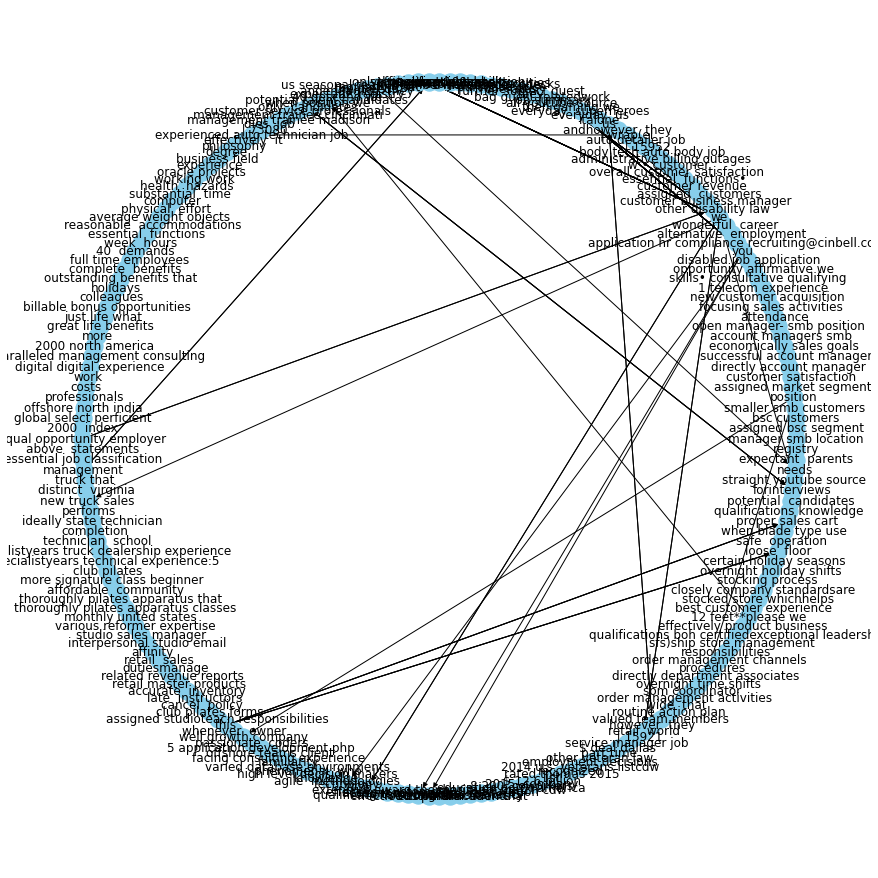

In [83]:
plot_graph(kg_df, use_circular=True)

### Topic Summarization with TextRank

In [ ]:
'''
Summarizes corpus with TextRank.
:parameter    
    :param corpus: str or list - dtf["text"]    
    :param ratio: length of the summary (ex. 20% of the text)
:return    
    list of summaries
'''
def textrank(corpus, ratio=0.2):    
    if type(corpus) is str:        
      corpus = [corpus]    
      lst_summaries = [gensim.summarization.summarize(txt, ratio=ratio) for txt in corpus]    
      return lst_summaries

## Apply the function to corpus
predicted = textrank(corpus=corpus_df.raw_sentences, ratio=0.2)
predicted[i]

### Clustering with TF-IDF and KMeans

In [88]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame

def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()
        
    ## new
    elif model_type == 'knearest':
        print('kneighbors')
        model = KNeighborsClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions) 
    matrix = confusion_matrix(y_test, predictions) ## new
    report = classification_report(y_test, predictions) ## new
    
    dic = {'accy': accy, 'matrix': matrix, 'report': report}
    return dic



In [140]:
tokens = word_tokenize(input_answer)
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
tokens = [re_punc.sub('', w) for w in tokens]
tokens = [word for word in tokens if word.isalpha()]
tokens = [word.lower() for word in tokens]
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]  

tokens = 'full time comanager austin tx sales'

In [141]:
# Add the target input_answer to the data

final_processed_text.append(tokens)

In [143]:
# Add new title to titles for input_answer

titles.append('target')

In [145]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


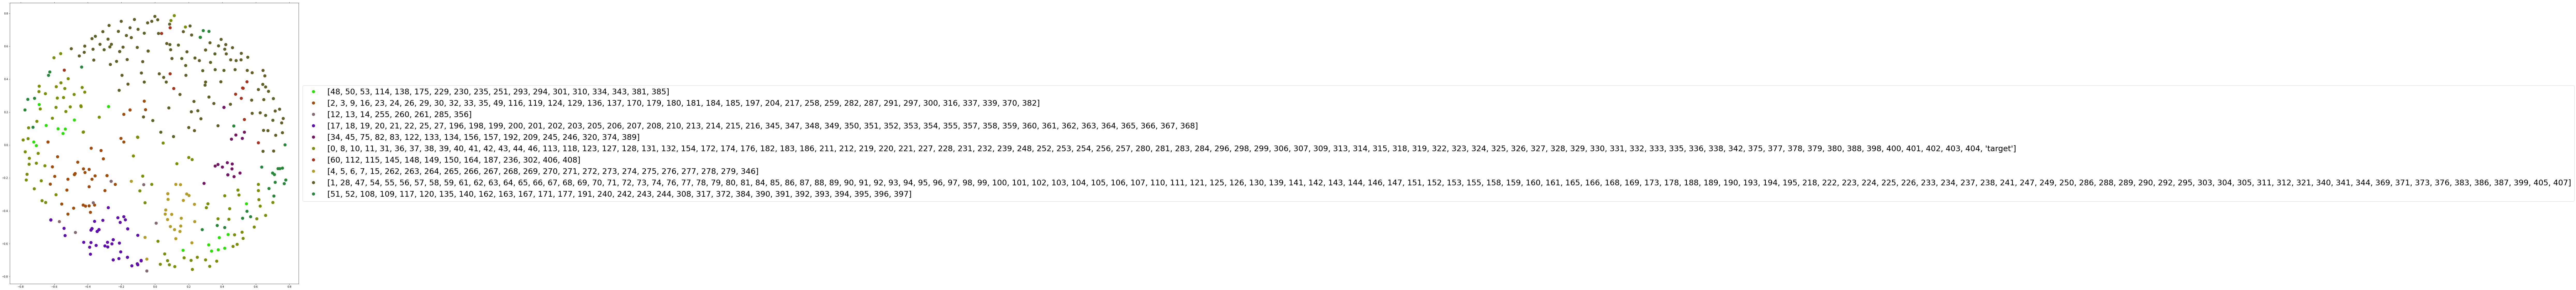

In [146]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =10)
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

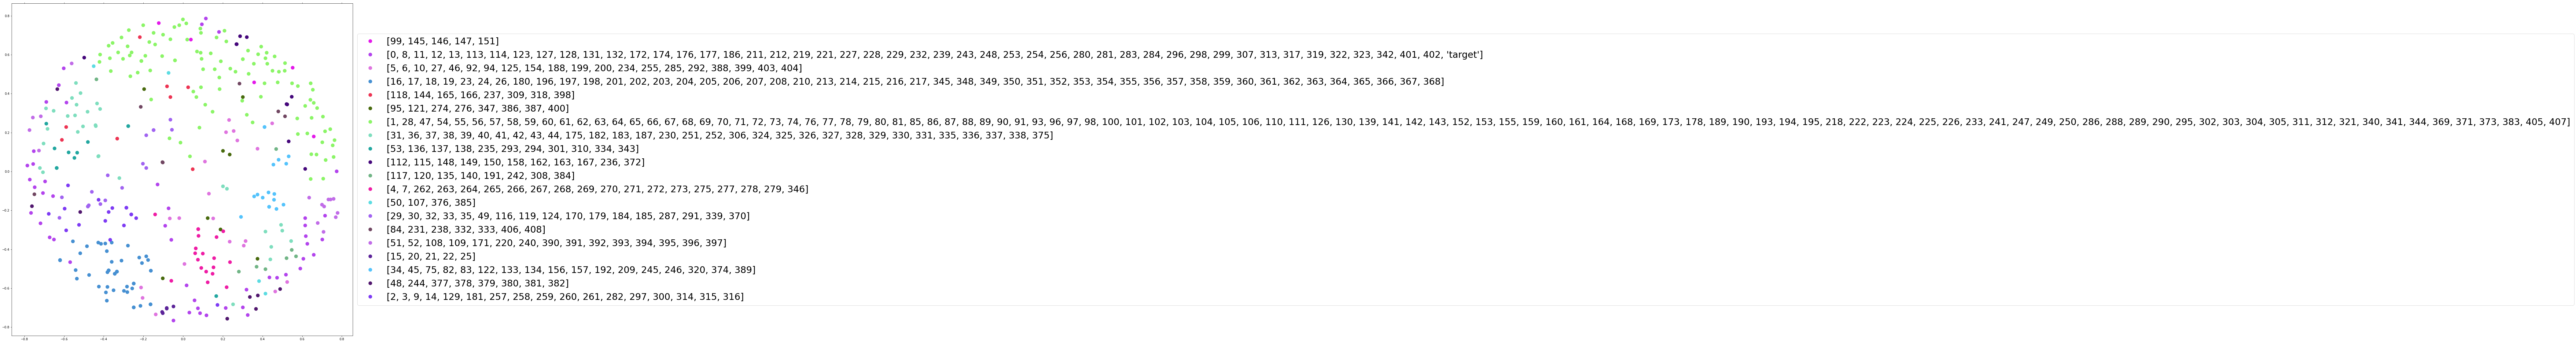

In [147]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =20)
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

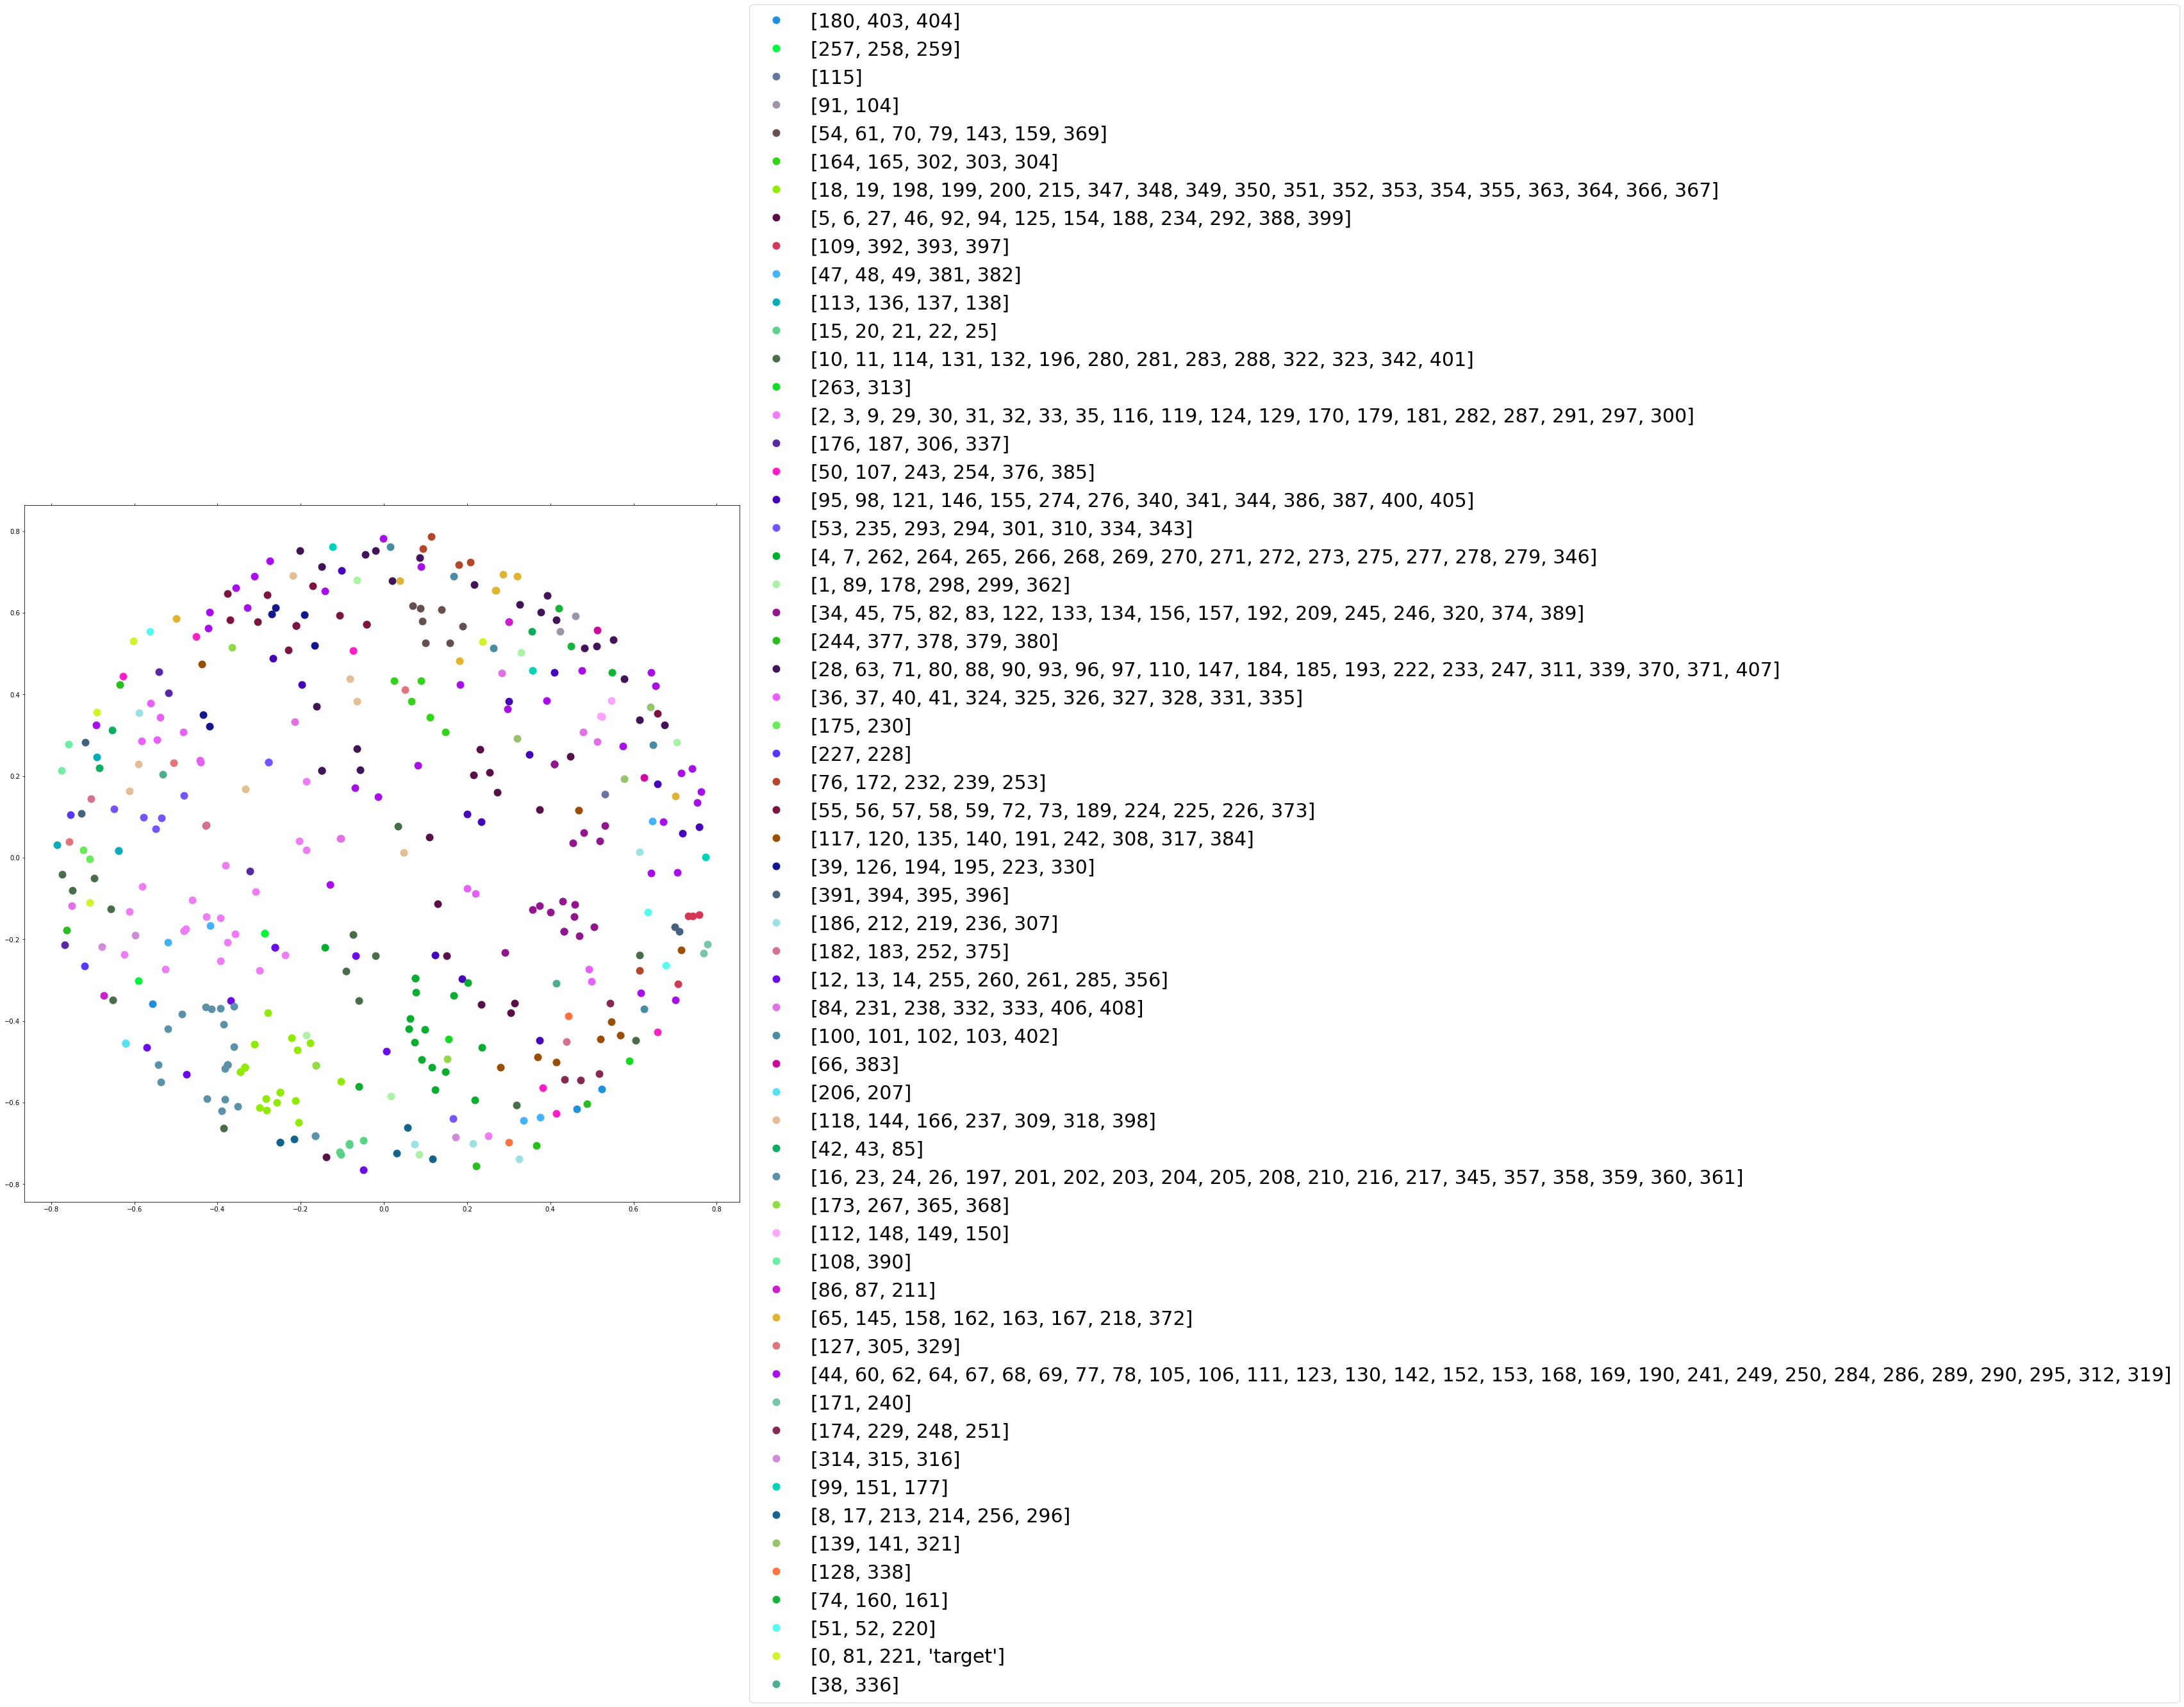

In [148]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =60)
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

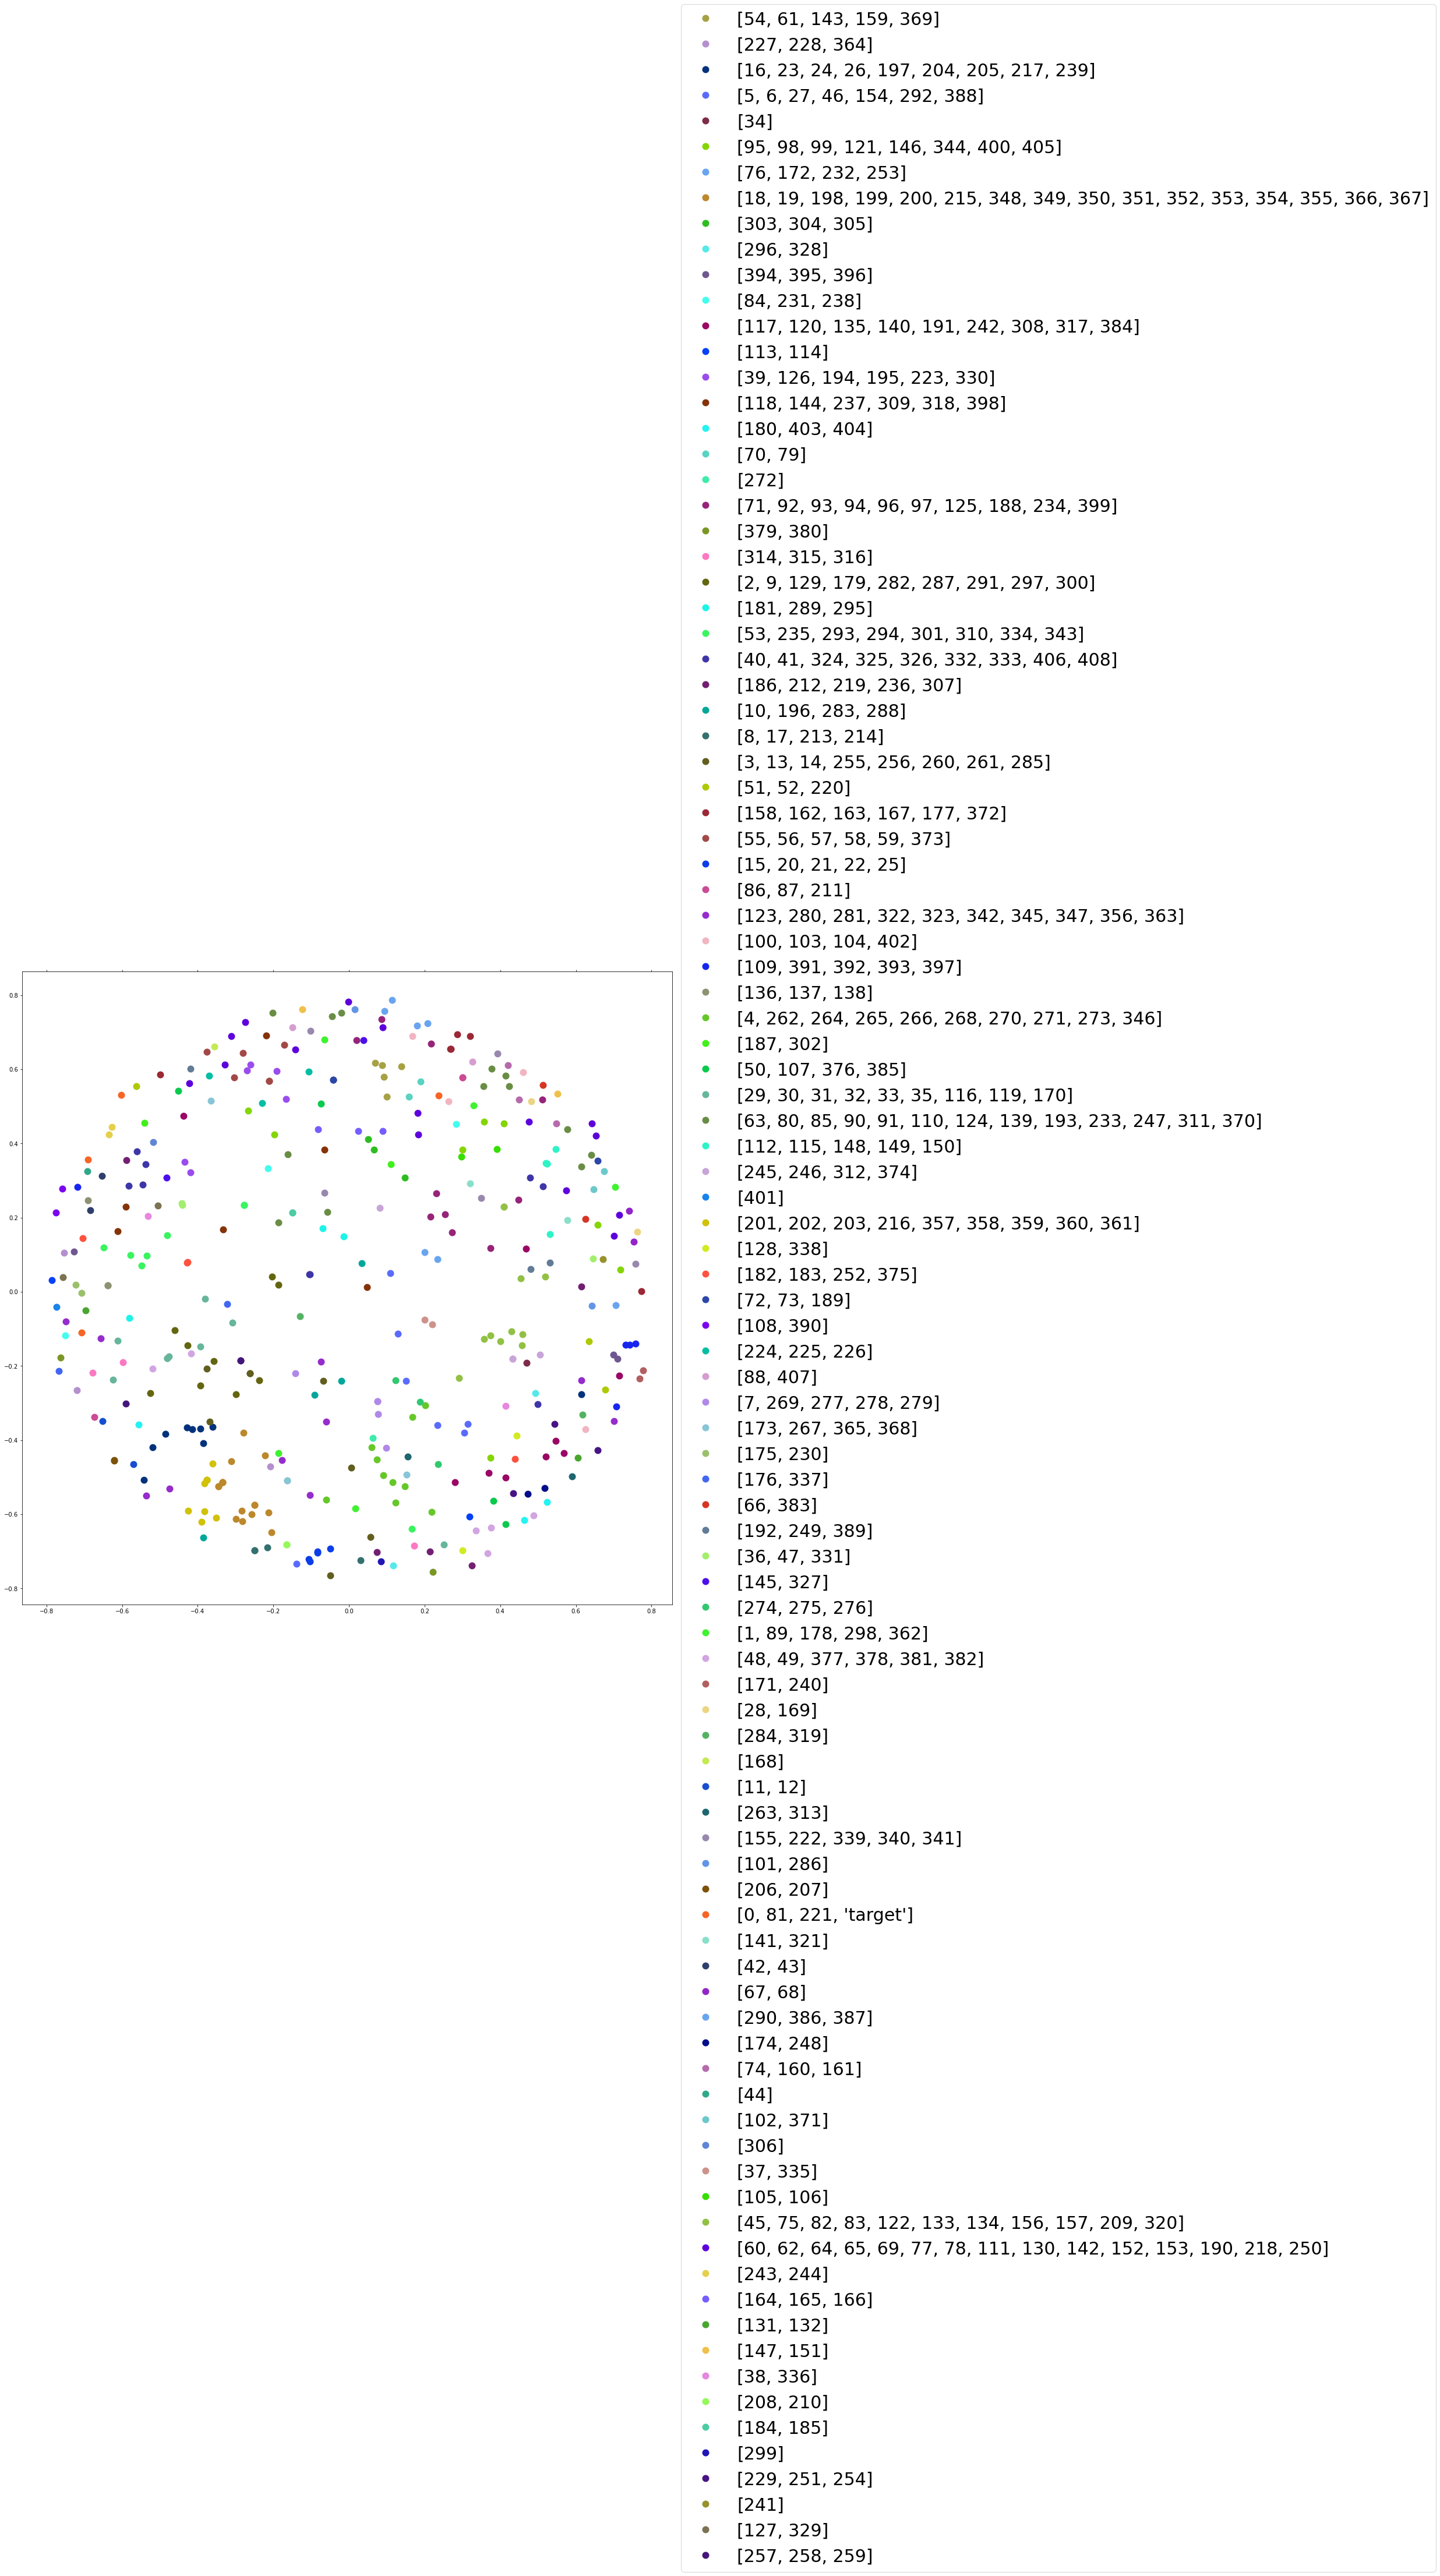

In [149]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =100)
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### Find the jobs matched

In [155]:
corpus_df[(corpus_df['job_id'] == 0) | (corpus_df['job_id'] == 81) | (corpus_df['job_id'] == 221)]

index                   country country_code date_added has_expired  \
0     8731  United States of America           US        NaN          No   
81   20618  United States of America           US        NaN          No   
221   8809  United States of America           US        NaN          No   

            job_board                                    job_description  \
0    jobs.monster.com  Apply Today. Train Tomorrow. Earn This Week!!A...   
81   jobs.monster.com  Qualifications, Experience and Capability Requ...   
221  jobs.monster.com  At Hertz, our Location Manager Trainees are th...   

                                       job_title              job_type  \
0                                !!! Apply Today             Full Time   
81   Automotive Service Technician Job in Austin             Full Time   
221                Manager Trainee Job in Austin  Full Time / Employee   

       location  ...                         old_sector  \
0    Austin, TX  ...  Sales/Retail/Business Development   
81   Austin, TX  ...    Installation/Maintenance/Repair   
221  Austin, TX  ...  Sales/Retail/Business Development   

                              uniq_id  \
0    0bde742227430ed8ea3cccff25687806   
81   f9e1ad0924ae2ed51b4621c5a5a6578f   
221  4ce399e0a90f31d0068cdb55ab35b83c   

                                       real_answer_des  \
0    Full Time. !!! Apply Today. Austin, TX. Sales/...   
81   Full Time. Automotive Service Technician Job i...   
221  Full Time / Employee. Manager Trainee Job in A...   

                                           real_answer job_id  \
0    Full Time. !!! Apply Today. Austin, TX. Sales/...      0   
81   Full Time. Automotive Service Technician Job i...     81   
221  Full Time / Employee. Manager Trainee Job in A...    221   

                                        processed_text  \
0    [apply, today, austin, salesretailbusiness, de...   
81   [automotive, service, technician, austin, aust...   
221  [employee, manager, trainee, austin, austin, s...   

                                         raw_sentences  \
0    [Full Time. !!!, Apply Today., Austin, TX., Sa...   
81   [Full Time., Automotive Service Technician Job...   
221  [Full Time / Employee., Manager Trainee Job in...   

                                                lemmas  \
0            [tx, sale, retail, business, development]   
81   [automotive, service, technician, job, tx, aut...   
221  [employee, manager, trainee, job, tx, sale, re...   

                                         lemmas_joined  \
0                  tx sale retail business development   
81   automotive service technician job tx automotiv...   
221  employee manager trainee job tx sale retail bu...   

                                  sentences_lemmatized  
0         [, , tx, sale retail business development, ]  
81   [, automotive service technician job, tx, auto...  
221  [employee, manager trainee job, tx, sale retai...  

[3 rows x 23 columns]